# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [14]:
%matplotlib inline
import os                             #highly annoying!  Even this didn't work, I had to fix it in my enviroment variables and restart
os.environ["OMP_NUM_THREADS"] = '1'

import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [15]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)   #uh oh...what's up with that warning??

C:\Users\Owner\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [16]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [81]:
df_offers.shape   #32 campaigns.  6 informative feature columns beyond ID.

(32, 7)

In [79]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)  #nice trick
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1  #Ok, so this is for pivoting later.
df_transactions.head()  #so we're still getting the warning, but also the output...

C:\Users\Owner\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [80]:
#another sanity check
df_transactions.shape   #.  Ok.  So we have a lot of transactions, but only 100 unique customers.

(324, 3)

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [18]:
#your turn  Before creating a pivot table, I want to check for NaNs.  Good:  none present.
a=df_transactions['offer_id'].isna().sum()
print(a)

0


In [19]:
#But when we make the matrix it will have to fill in the zeroes for the offers customers didn't respond to
#merge dfs first
merged = pd.merge(df_transactions, df_offers)
table = merged.pivot_table(values='n', index=['customer_name'],   #now notice the way I did this it's not including all the other columns...
                       columns=['offer_id'], fill_value=0)
#I would like to see this...
table.head()
#ok

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [75]:
#out of curiosity:  this looks ok.  Moving on...
print(merged['customer_name'].nunique())  #hmm, ok, now it's a little clearer; we only have 100 unique customers.

100


In [66]:
merged.shape #ok so now the merged dataframe has 324 rows, 9 columns. So...

(324, 9)

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [21]:
# your turn.  Ok, naive choice, I'll try the .to_numpy on the whole df...maybe it'll ignore the first col of names?
x_cols = table.to_numpy()
print(x_cols) #

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


{2: 271.03125, 3: 244.64509246088193, 4: 232.37153110047848, 5: 229.26467710371813, 6: 199.15157536698894, 7: 191.7809750927398, 8: 184.55524132730025, 9: 178.38327294685993, 10: 168.3468678380443}


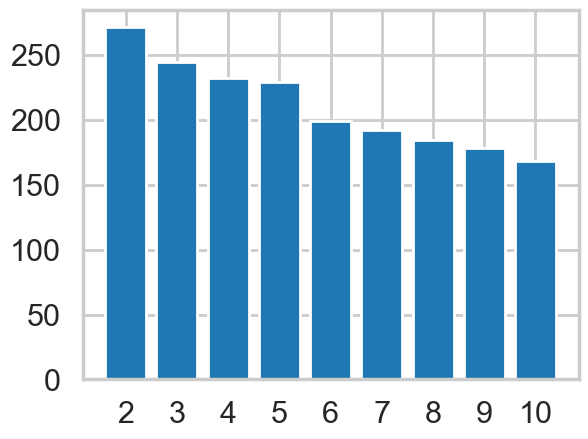

In [22]:
#Now for k-means:  (after some experimenting)


from sklearn.cluster import KMeans
import numpy as np
dict_k = {}
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x_cols)
    dict_k[k] = kmeans.inertia_
print(dict_k)  #looks junky, let's sort this next
output = dict(sorted(dict_k.items(), key=lambda item: item[1], reverse=True))

K_values = list(output.keys())   #Setting things up for plotting
SS_values = list(output.values())

plt.bar(range(len(dict_k)), SS_values, tick_label=K_values)  #Jedi: "this is not the bar chart you are looking for"
#plt.plot(K_values, SS_values, tick_label=K_values)  #why does this suck and not work?
plt.show()

In [23]:
#the chart above keeps dropping: where is the elbow?  One might say it drops nicely at 5, then keeps dropping by gradually...
#Next up:  the actual number of items/cluster
data_km =[]
df_km=pd.DataFrame(data_km)  #made a blank dataframe, will fill with these values
kmeans_best = KMeans(n_clusters=5)
kmeans_best.fit(x_cols)
df_km['kmean'] = kmeans_best.labels_  #this just records what cluster
print(df_km['kmean'].value_counts())  #and then counts how many in each

kmean
1    38
4    20
2    19
3    18
0     5
Name: count, dtype: int64


<BarContainer object of 5 artists>

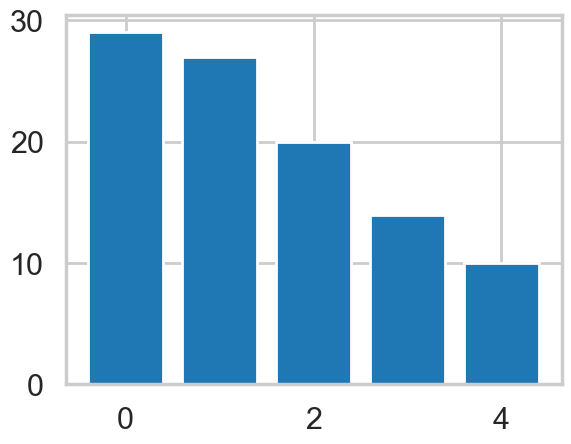

In [13]:
#now for that bar chart--though I feel like the way I'm going about this is roundabout and clumsy
clusters = [0,1,2,3,4]  #feels wrong to do this manually, sigh
counts = df_km['kmean'].value_counts()
plt.bar(clusters, counts)   #meh 

## Conclusions--ex 2

In [ ]:
#Elbow?  What elbow?
#I chose k=5 clusters but that seems arbitrary.  That is the real challenge.  Let's see what other techniques can tell me.
#A lot would depend on whether we believe there are that many customer segments

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.12976508334276524
For n_clusters = 3 The average silhouette_score is : 0.08710662290736483
For n_clusters = 4 The average silhouette_score is : 0.12042758748935155
For n_clusters = 5 The average silhouette_score is : 0.10087148242195733
For n_clusters = 6 The average silhouette_score is : 0.11092707718995178
For n_clusters = 7 The average silhouette_score is : 0.1087617048378143
For n_clusters = 8 The average silhouette_score is : 0.1157123164572949
For n_clusters = 9 The average silhouette_score is : 0.10314757429326486
For n_clusters = 10 The average silhouette_score is : 0.10416369064382269


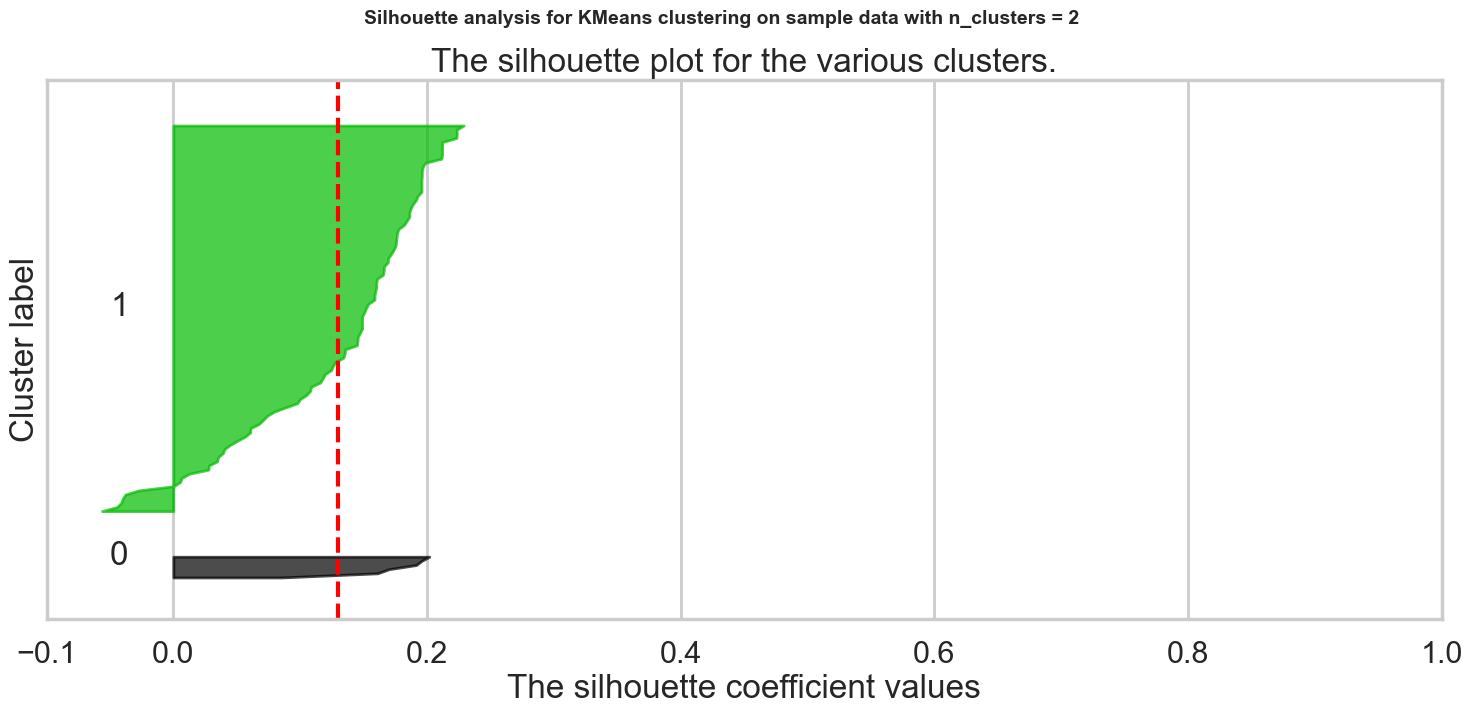

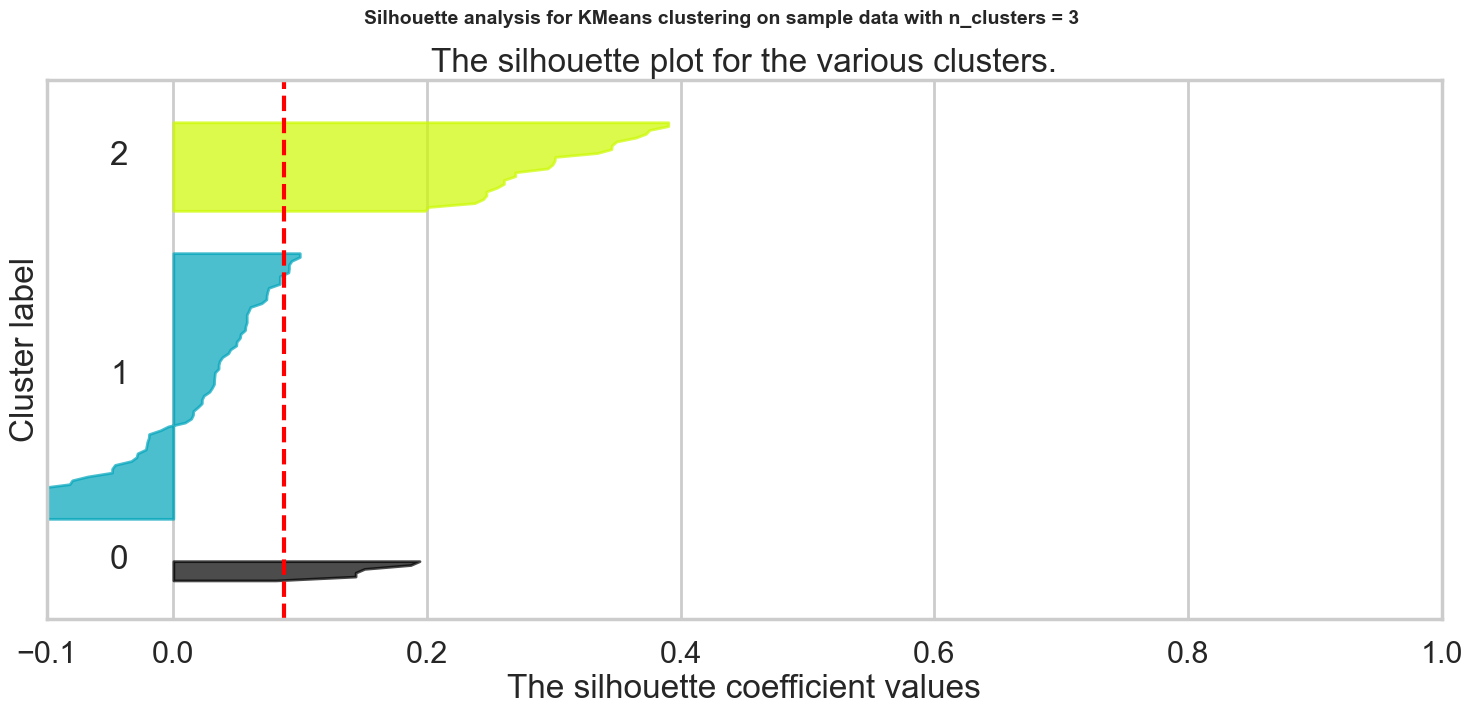

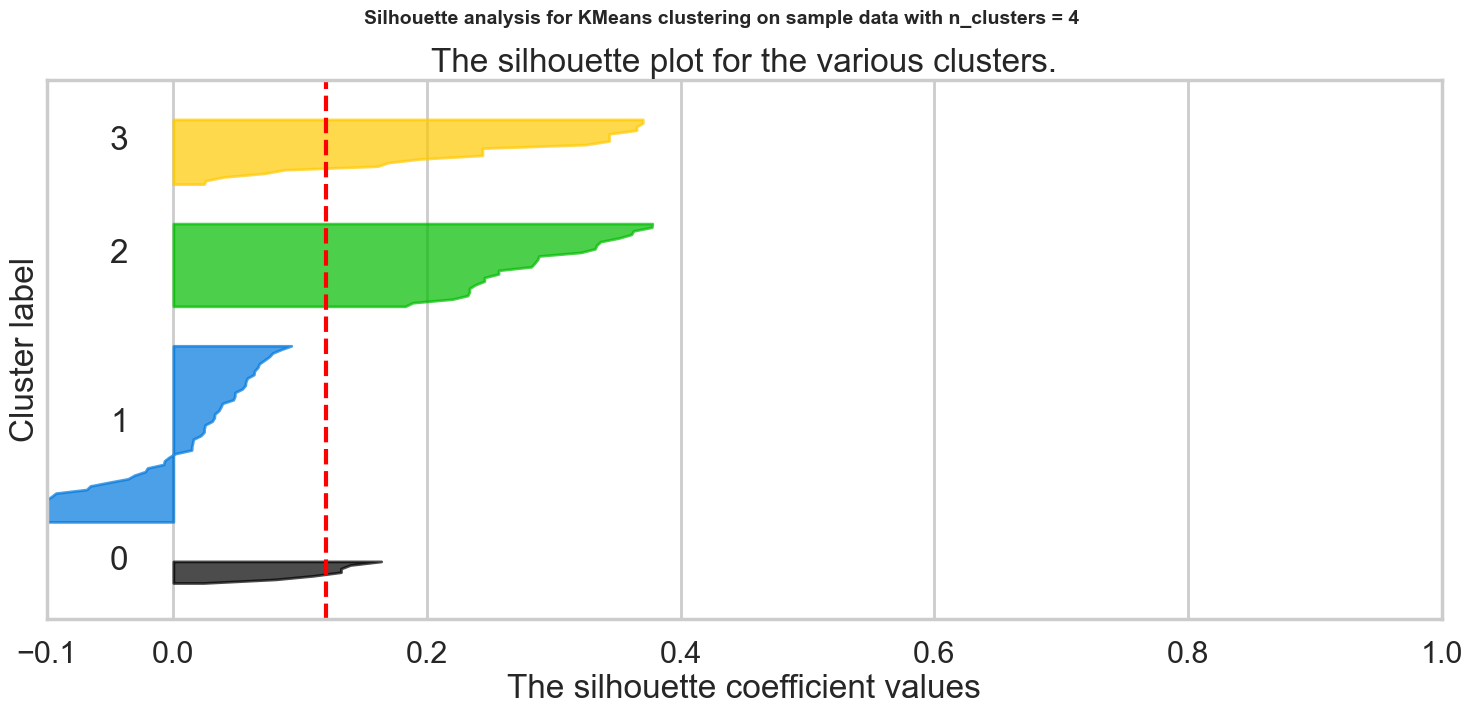

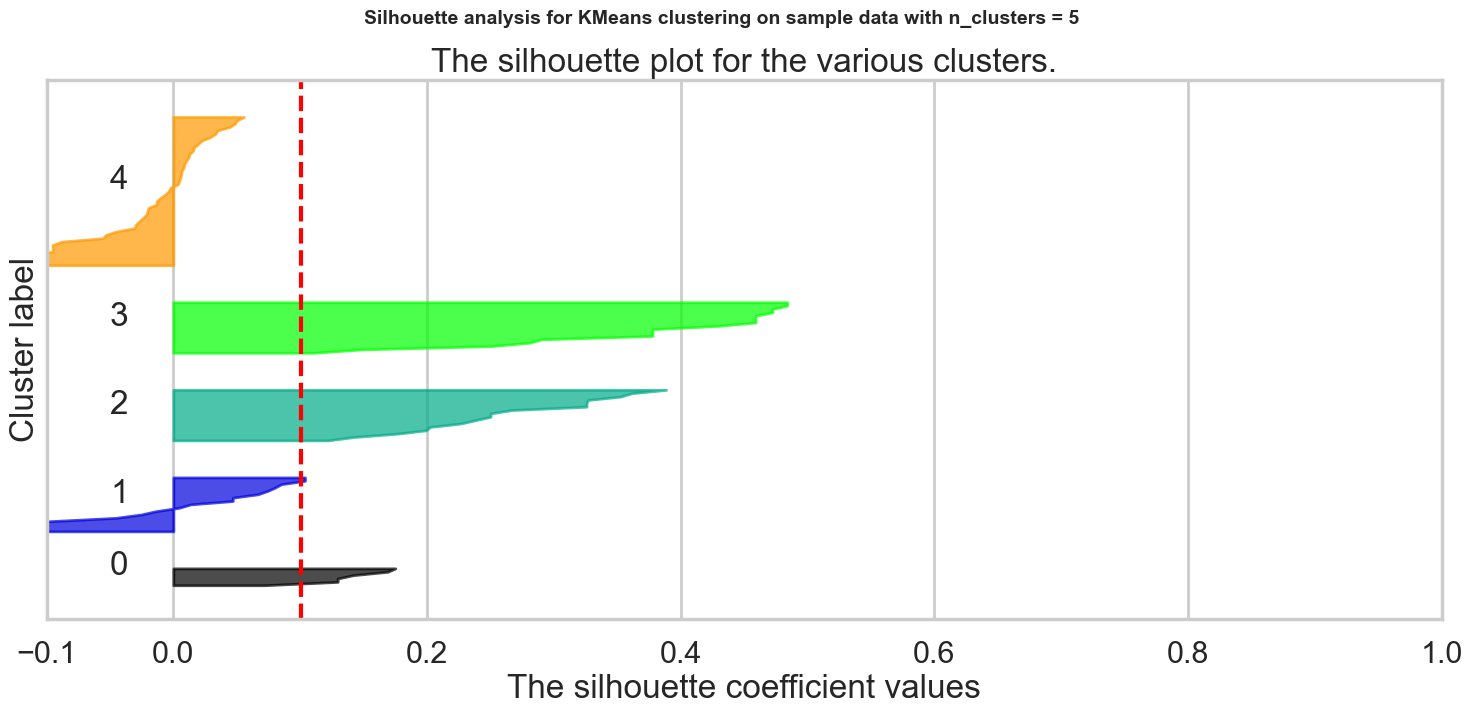

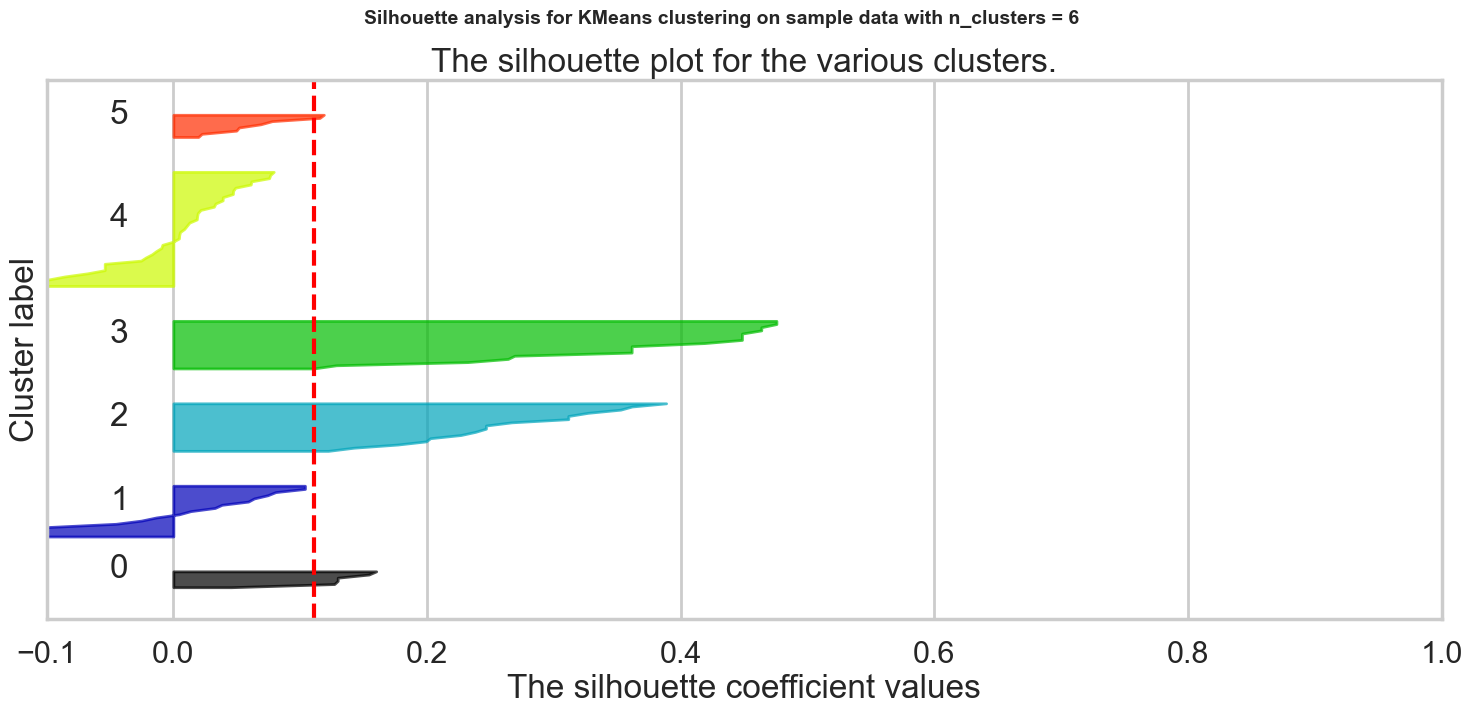

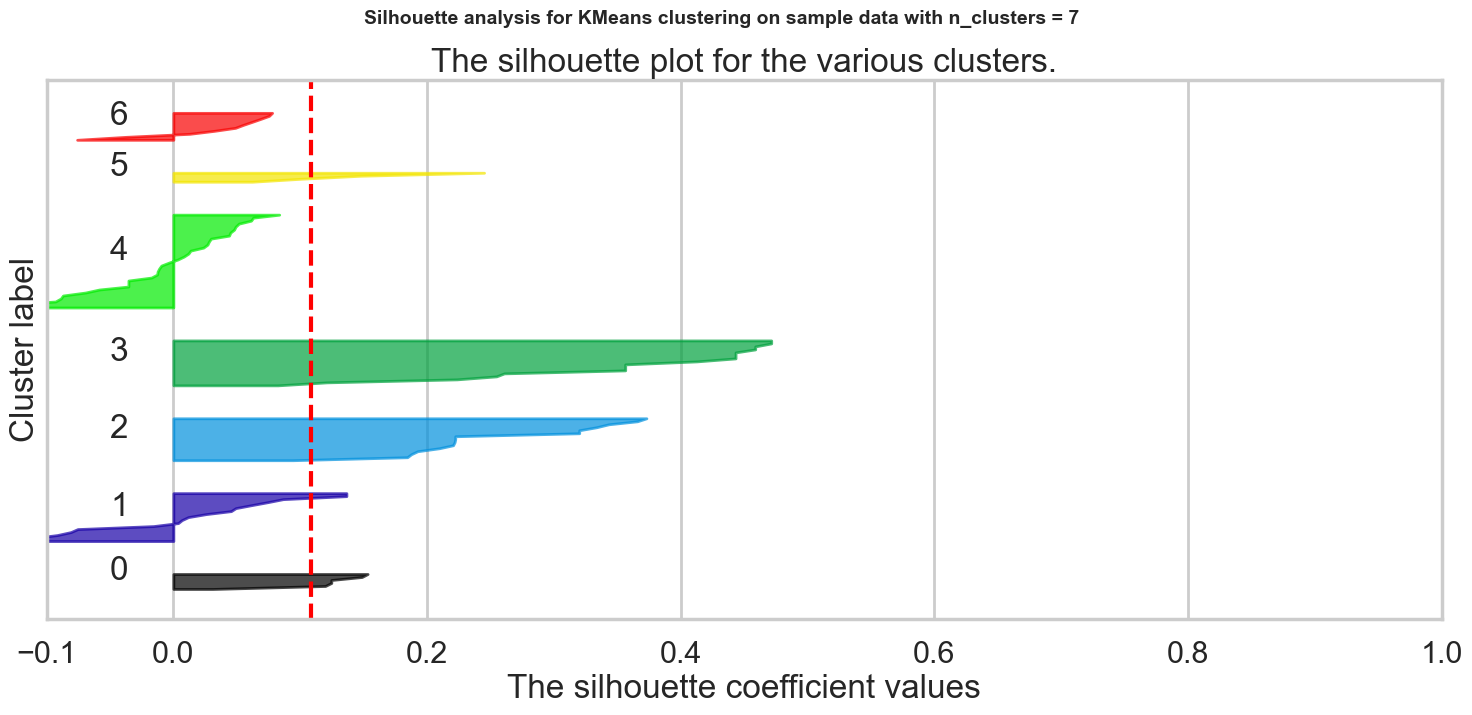

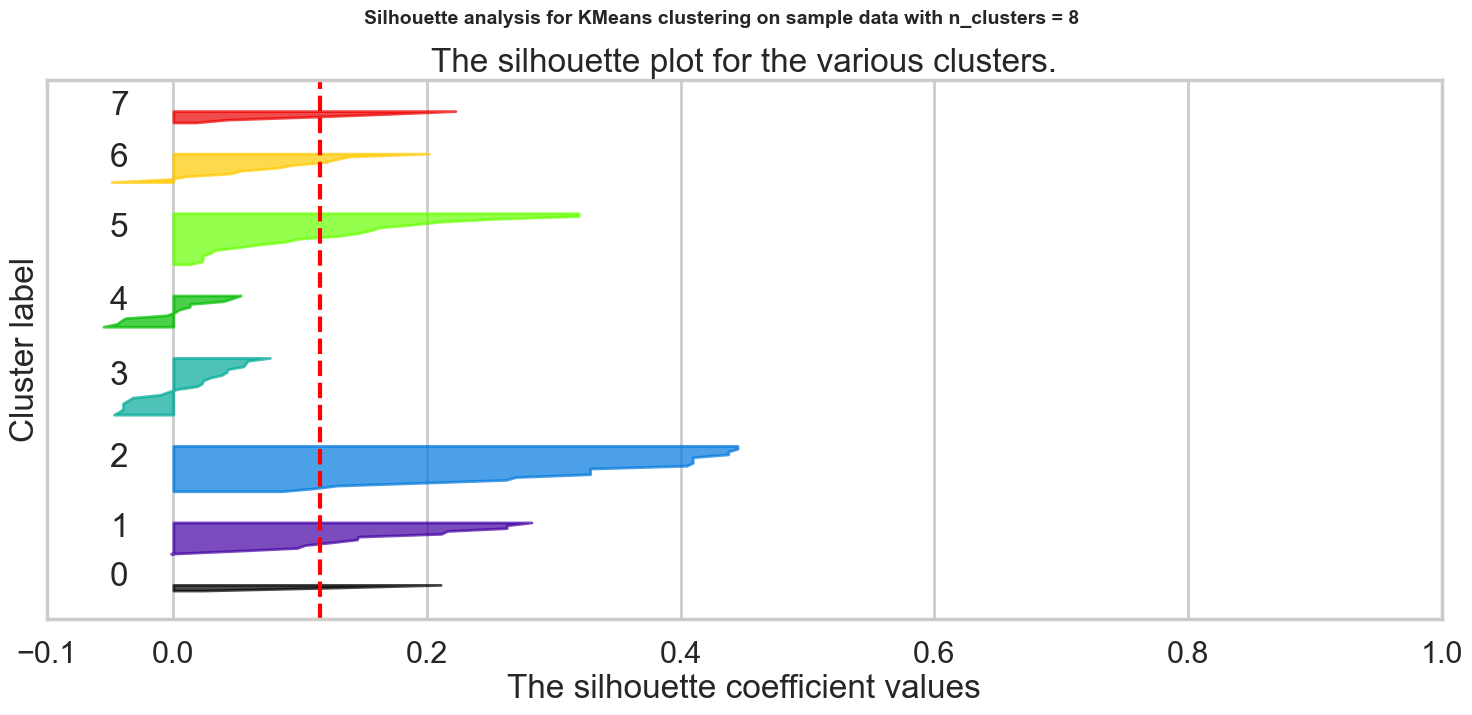

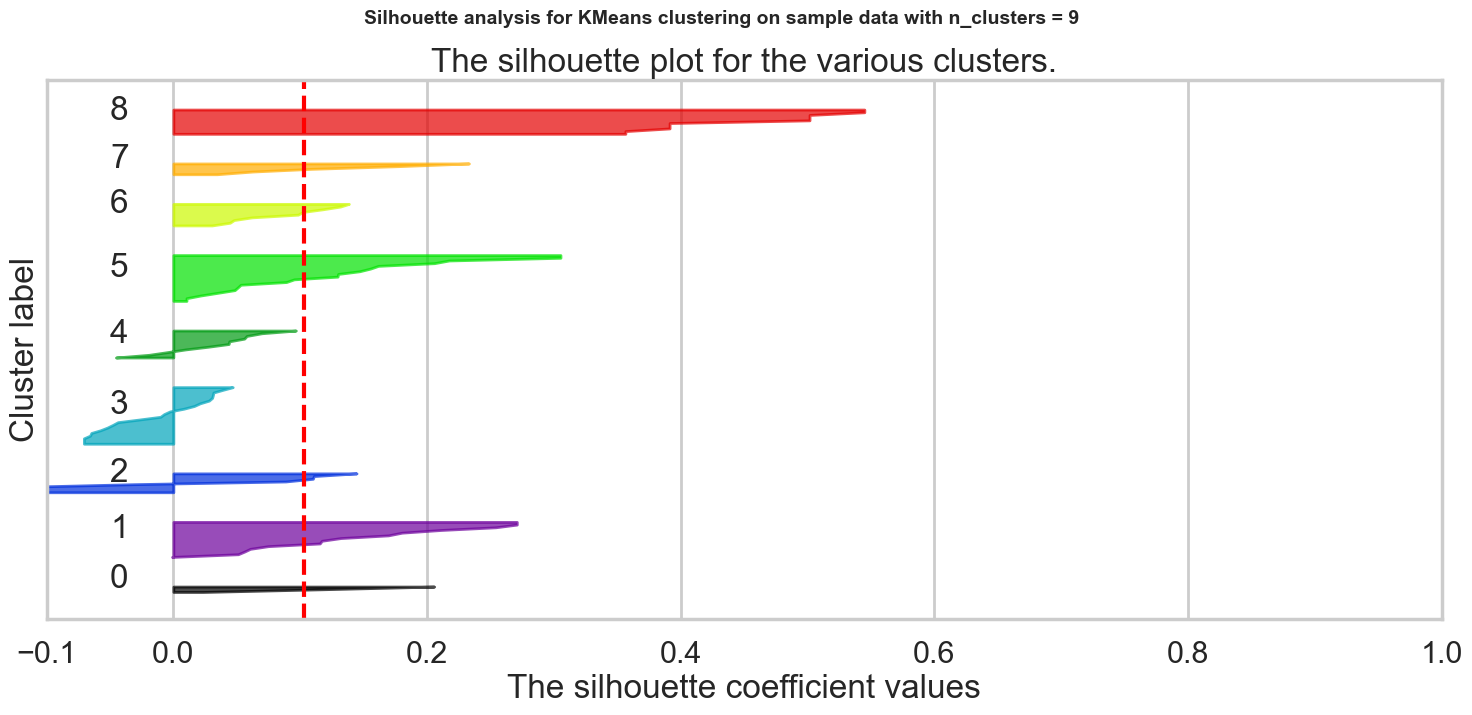

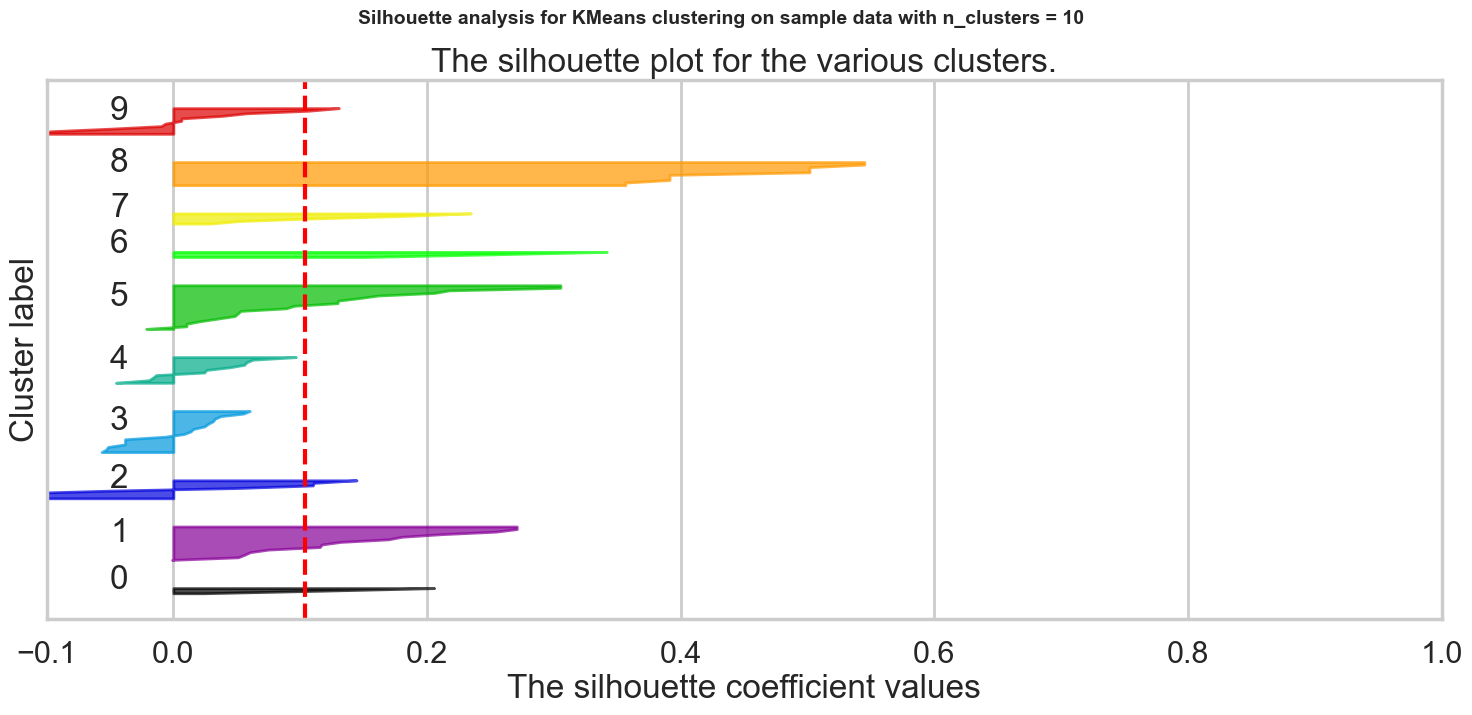

In [24]:
# Your turn.  Duly importing some tools per the linked article: 
from sklearn.datasets import make_blobs  #don't really need this, because we have our own data
#the code from the article is carefully edited as a result
from sklearn.metrics import silhouette_samples, silhouette_score
#this is the setup for plotting--copied but edited from the article
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]   #Expanded this list to 10 per the earlier exercises
for n_clusters in range_n_clusters:  
    # Create a subplot with 1 row and 2 columns
    fig, ax1= plt.subplots(1, 1)                 #per the directions, I don't really want the scatterplot, just the silhouette
    fig.set_size_inches(18, 7)

    # This will be the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])     #HERE we have to be careful with the variable inputs

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.  ##Yeah, that's what I *should* have done earlier..
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)  #again, careful with the inputs
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )     
#further refining the plots:

# Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
# 2nd Plot showing the actual clusters formed    #NOTE that I removed this part.
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()

In [43]:
#Right now this doesn't look good, in all cases I see clusters with silhouette coefficient values under .25.
#Only 2 clusters looks marginally ok.  For the runs with a higher number of clusters, two seem to hit a high enough 
#value pretty consistently.  Hmmf.  The average silhouette scores, by the way, are all pretty rotten, at less than .25, with
#.13 being the max.  Disappointing.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

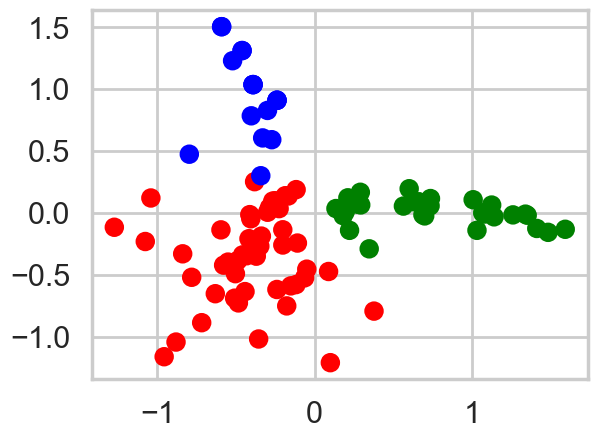

In [25]:
#your turn   
import sklearn.decomposition
import matplotlib.colors

#initialize model with n_clusters = 3 
model = sklearn.cluster.KMeans(n_clusters=3)
# kind of nice we can fit and predict in one line with fit_predict() on the data
cluster_assignments = model.fit_predict(x_cols)

# for color coding set up a map...
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# PCA will use n_components=2 as requested.  x and y are pricipal components 1 and 2
pca = sklearn.decomposition.PCA(n_components=2)
x, y = zip(*pca.fit_transform(x_cols))
plt.scatter(x, y, c=cluster_assignments.tolist(), cmap=cmap)

In [ ]:
#Well here the 3 clusters look pretty good!

In [89]:
#let's not forget: Create a data frame with the following fields: customer name, cluster id the customer belongs to
#and the two PCA components (label them `x` and `y`)

cluster_id=cluster_assignments.tolist()   #this entire exercise was surprisingly painful
x_list=list(x)
y_list=list(y)
cust_list = list(merged['customer_name'])
df_pca = pd.DataFrame(data=[cust_list,x_list,y_list,cluster_id])
new_df = df_pca.T
new_df.columns=['cust_list','x_list','y_list','cluster_id']
new_df.head()

,cust_list,x_list,y_list,cluster_id
0,Smith,1.00758,0.108215,1
1,Smith,-0.287539,0.044715,0
2,Johnson,-0.392032,1.038391,2
3,Johnson,0.699477,-0.022542,1
4,Johnson,0.088183,-0.471695,0


In [95]:
new_df.shape  #ok...

(324, 4)

In [93]:
#I would like to take the merged df which has the same number of rows as new_df, sort by cust name, append cluster_id then
#take a look at features...
merged_sorted = merged.sort_values(by=['customer_name'])
merged_sorted.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
128,Adams,29,1,November,Pinot Grigio,6,87,France,False
129,Adams,30,1,December,Malbec,6,54,France,False
127,Adams,18,1,July,Espumante,6,50,Oregon,False
102,Allen,9,1,April,Chardonnay,144,57,Chile,False
103,Allen,27,1,October,Champagne,72,88,New Zealand,False


In [97]:
#ok, that's a start.  let me order the new_df, too:
new_df_sorted = new_df.sort_values(by=['cust_list'])
new_df_sorted.head()

,cust_list,x_list,y_list,cluster_id
128,Adams,None,None,None
129,Adams,None,None,None
127,Adams,None,None,None
102,Allen,None,None,None
103,Allen,None,None,None


In [98]:
#uh oh, 'none' showing up in cluster_id, that's a worry.
print(new_df_sorted['cluster_id'].nunique())  #well, what the heck?

3


In [99]:
#I don't like where this is going but...
merged_sorted['cluster'] = new_df_sorted['cluster_id']
merged_sorted.head()   #come on, you have to be joking.  Where are these 'none' values coming from?

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster
128,Adams,29,1,November,Pinot Grigio,6,87,France,False,None
129,Adams,30,1,December,Malbec,6,54,France,False,None
127,Adams,18,1,July,Espumante,6,50,Oregon,False,None
102,Allen,9,1,April,Chardonnay,144,57,Chile,False,None
103,Allen,27,1,October,Champagne,72,88,New Zealand,False,None


In [102]:
#well let's try a little more, before I hook up to the tailpipe.
merged_sorted_c0 = merged_sorted[merged_sorted['cluster']==0]
merged_sorted_c0.head(30)  #well, maybe there's something to work with here after all. 

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster
32,Anderson,26,1,October,Pinot Noir,144,83,Australia,False,0
10,Brown,30,1,December,Malbec,6,54,France,False,0
8,Brown,7,1,March,Prosecco,6,40,Australia,True,0
82,Clark,11,1,May,Champagne,72,85,France,False,0
81,Clark,4,1,February,Champagne,72,48,France,True,0
19,Davis,12,1,May,Prosecco,72,83,Australia,False,0
22,Garcia,14,1,June,Merlot,72,64,Chile,False,0
23,Garcia,15,1,June,Cabernet Sauvignon,144,19,Italy,False,0
74,Gonzalez,31,1,December,Champagne,72,89,France,False,0
95,Hall,22,1,August,Champagne,72,63,France,False,0


In [103]:
#cluster 0 has a LOT of champaign and prosecco orders.
merged_sorted_c1 = merged_sorted[merged_sorted['cluster']==1]
merged_sorted_c1.head(30)   #well, there seems to be more Pinot Noir and Pinot Grigio, and a bit more Malbec here

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster
31,Anderson,24,1,September,Pinot Noir,6,34,Italy,False,1
9,Brown,29,1,November,Pinot Grigio,6,87,France,False,1
84,Clark,31,1,December,Champagne,72,89,France,False,1
21,Davis,25,1,October,Cabernet Sauvignon,72,59,Oregon,True,1
20,Davis,22,1,August,Champagne,72,63,France,False,1
73,Gonzalez,9,1,April,Chardonnay,144,57,Chile,False,1
78,Harris,19,1,July,Champagne,12,66,Germany,False,1
75,Harris,4,1,February,Champagne,72,48,France,True,1
44,Hernandez,29,1,November,Pinot Grigio,6,87,France,False,1
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False,1


In [104]:
merged_sorted_c2 = merged_sorted[merged_sorted['cluster']==2]
merged_sorted_c2.head(30) #more summer months here, and more Cab Sauvignon

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster
83,Clark,28,1,November,Cabernet Sauvignon,12,56,France,True,2
76,Harris,6,1,March,Prosecco,144,86,Chile,False,2
79,Harris,22,1,August,Champagne,72,63,France,False,2
52,Jackson,11,1,May,Champagne,72,85,France,False,2
53,Jackson,15,1,June,Cabernet Sauvignon,144,19,Italy,False,2
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False,2
11,Jones,8,1,March,Espumante,6,45,South Africa,False,2
65,Lopez,15,1,June,Cabernet Sauvignon,144,19,Italy,False,2
66,Lopez,16,1,June,Merlot,72,88,California,False,2
29,Martinez,25,1,October,Cabernet Sauvignon,72,59,Oregon,True,2


In [ ]:
#I don't really have a great story to tell except that 1 cluster is more champagne focused, another is more summer/Cabernet, and the last
#is a bit of a grab bag.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

Text(0, 0.5, 'Proportion of Variance Explained')

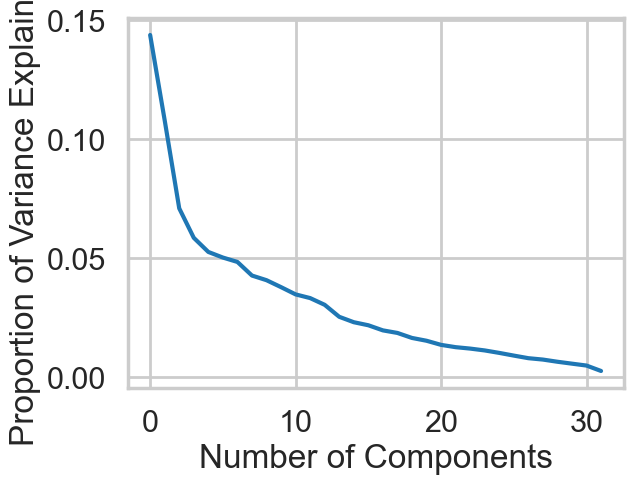

In [56]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)  ;-( grrrr
# for the variance--use this handy method
var = pca.explained_variance_ratio_

# Plot() it 
plt.plot(range(len(var)), var)

# Label the axes
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")

In [ ]:
#well, it looks like it drops pretty sharply at 3, actually.  After three it continues to descend, but gradually.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [111]:
# Your turn
# Fo-finity shminity
from sklearn.cluster import affinity_propagation
from sklearn.metrics.pairwise import euclidean_distances
S = -euclidean_distances(x_cols, squared=True)
cluster_centers_indices, labels = affinity_propagation(S, random_state=0)
n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)


Estimated number of clusters: 14


In [112]:
#14 clusters, huh?  I'm not sure I buy that.  Might just be clustering on varietal:
print(merged['varietal'].nunique())  #huh, even more than the varietals, thought there were more.

9


In [114]:
# I'd be hard-pressed to explain the results with 14 clusters.  Moving on:
#spectral clustering.  Error msg says it wants a 2-d, square matrix.

#Yeah well, *I* want a pony.  But I can't have one.

from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, affinity='precomputed', n_init=10,
                        assign_labels='kmeans')
sc.fit_predict(x_cols)  
#honestly I don't know what to set the 'affinity' parameter to, in order for this to work
#and at this point my 3-5 hour assignment long exceeded 10 hours so shove it
#and thanks again FOR NO HELPFUL GUIDANCE WHATSOEVER

ValueError: array must be 2-dimensional and square. shape = (100, 32)

In [115]:
#Well how about agglomerative clustering, maybe this one will SUCK LESS.
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering().fit(x_cols)
clustering

AgglomerativeClustering()

In [117]:
#honestly I don't know how to proceed with this.  How about teaching this stuff first?
#4, DBSCAN.
from sklearn.cluster import DBSCAN
clustering_db = DBSCAN(eps=.5, min_samples=2).fit(x_cols)  #I set eps to default
labels=clustering_db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 8
Estimated number of noise points: 81


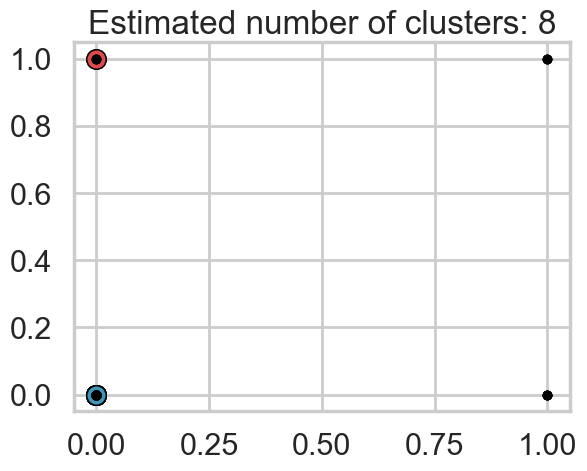

In [120]:
#well, 8 clusters seems a little more in line with the number of varietals.  Otherwise I
#tried to plot, but it looked terrible.  At this point, stick a fork in me, I'm done.  I would go with dg scan
#out of these four, if for no other reason than it seems slightly reasonable and it
#kind of works.

In [ ]:
#Not proud of this work and super annoyed, frankly.